In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#reformating of .csv format in order to be usable
df = pd.read_csv("datasets/effectifs.csv",sep=';')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
df.head()

,annee,patho_niv1,patho_niv2,patho_niv3,top,cla_age_5,sexe,region,dept,Ntop,Npop,prev,Niveau prioritaire,libelle_classe_age,libelle_sexe,tri
0,2023,Maladies inflammatoires ou rares ou infection VIH,Maladies rares,Mucoviscidose,RAR_MUC_IND,95et+,9,28,999,NaN,15550,NaN,3,plus de 95 ans,tous sexes,78.00
1,2023,Maladies inflammatoires ou rares ou infection VIH,Maladies rares,Mucoviscidose,RAR_MUC_IND,95et+,9,32,59,NaN,8460,NaN,3,plus de 95 ans,tous sexes,78.00
2,2023,Maladies inflammatoires ou rares ou infection VIH,Maladies rares,Mucoviscidose,RAR_MUC_IND,95et+,9,32,60,NaN,2470,NaN,3,plus de 95 ans,tous sexes,78.00
3,2023,Maladies inflammatoires ou rares ou infection VIH,Maladies rares,Mucoviscidose,RAR_MUC_IND,95et+,9,32,62,NaN,5010,NaN,3,plus de 95 ans,tous sexes,78.00
4,2023,Maladies inflammatoires ou rares ou infection VIH,Maladies rares,Mucoviscidose,RAR_MUC_IND,95et+,9,32,80,NaN,2220,NaN,3,plus de 95 ans,tous sexes,78.00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216400 entries, 0 to 5216399
Data columns (total 16 columns):
 #   Column              Dtype  
---  ------              -----  
 0   annee               int64  
 1   patho_niv1          object 
 2   patho_niv2          object 
 3   patho_niv3          object 
 4   top                 object 
 5   cla_age_5           object 
 6   sexe                int64  
 7   region              int64  
 8   dept                object 
 9   Ntop                float64
 10  Npop                int64  
 11  prev                float64
 12  Niveau prioritaire  object 
 13  libelle_classe_age  object 
 14  libelle_sexe        object 
 15  tri                 float64
dtypes: float64(3), int64(4), object(9)
memory usage: 636.8+ MB


In [5]:
df.describe()

,annee,sexe,region,Ntop,Npop,prev,tri
count,5216400.00,5216400.00,5216400.00,3833965.00,5216400.00,3833965.00,5148360.00
mean,2019.00,4.08,51.05,5544.95,103235.19,6.22,39.41
std,2.58,3.58,29.45,159030.85,989288.23,15.95,22.52
min,2015.00,1.00,1.00,10.00,10.00,0.00,1.00
25%,2017.00,1.00,27.00,50.00,7710.00,0.27,20.00
50%,2019.00,2.00,52.00,200.00,17040.00,0.98,39.00
75%,2021.00,9.00,76.00,950.00,42670.00,4.21,58.00
max,2023.00,9.00,99.00,68833510.00,68833510.00,100.00,78.00


In [6]:
df["Ntop"] = df["Ntop"].fillna(5)
# In accordance with statistical confidentiality laws (law of June 7, 1951) and to ensure that individuals cannot be directly or indirectly identified, no information on patient numbers is disclosed when the number of patients treated is less than 10. 
# Looking at this information we have decided to fix at 5 the number Ntop filed with NaN

#reformate l'age class label pour permettre un tri correct après
df["libelle_classe_age"] = df["libelle_classe_age"].replace(
    {"de 5 à 9 ans": "de 05 à 9 ans"}
)


In [7]:
df.columns

Index(['annee', 'patho_niv1', 'patho_niv2', 'patho_niv3', 'top', 'cla_age_5',
       'sexe', 'region', 'dept', 'Ntop', 'Npop', 'prev', 'Niveau prioritaire',
       'libelle_classe_age', 'libelle_sexe', 'tri'],
      dtype='object')

In [8]:
#selction of targeted data
df = df[["annee" , "patho_niv1" , "patho_niv2" , "patho_niv3" , "libelle_classe_age","sexe","dept", "region","Ntop","Npop","prev","top"]]


In [9]:
# ----- OPTIMISATION -----

# Création d'une copie pour ne pas modifier df
df_opt = df.copy()

# Colonnes catégorielles
cols_categorical = [
    "patho_niv1","patho_niv2","patho_niv3",
    "libelle_classe_age","dept","region","top"
]

for col in cols_categorical:
    df_opt[col] = df_opt[col].astype("category")

# Types numériques optimisés
df_opt["sexe"]  = df_opt["sexe"].astype("int8")
df_opt["annee"] = df_opt["annee"].astype("int16")

df_opt["Ntop"] = pd.to_numeric(df_opt["Ntop"], errors="coerce").astype("float32")
df_opt["Npop"] = pd.to_numeric(df_opt["Npop"], errors="coerce").astype("float32")
df_opt["prev"] = pd.to_numeric(df_opt["prev"], errors="coerce").astype("float32")

# Sauvegarde en parquet optimisé
df_opt.to_parquet("datasets/cleaned.parquet", compression="snappy")



In [20]:
dept_to_region = (
    df[df["dept"] != "999"][["dept", "region"]]
    .drop_duplicates()
    .set_index("dept")["region"]
    .to_dict()
)
dept_to_region["999"] = 99  # code 'France entière' dans les régions

values_dict = {
    "age": df["libelle_classe_age"].unique().tolist(),
    "dept": df["dept"].unique().tolist(),
    "region": df["region"].unique().tolist(),
    "dept_to_region": dept_to_region
}
values_dict

{'age': ['plus de 95 ans',
  'tous âges',
  'de 0 à 4 ans',
  'de 05 à 9 ans',
  'de 10 à 14 ans',
  'de 15 à 19 ans',
  'de 20 à 24 ans',
  'de 25 à 29 ans',
  'de 30 à 34 ans',
  'de 35 à 39 ans',
  'de 40 à 44 ans',
  'de 45 à 49 ans',
  'de 50 à 54 ans',
  'de 55 à 59 ans',
  'de 60 à 64 ans',
  'de 65 à 69 ans',
  'de 70 à 74 ans',
  'de 75 à 79 ans',
  'de 80 à 84 ans',
  'de 85 à 89 ans',
  'de 90 à 94 ans'],
 'dept': ['999',
  '59',
  '60',
  '62',
  '80',
  '10',
  '51',
  '55',
  '67',
  '68',
  '29',
  '56',
  '16',
  '17',
  '19',
  '23',
  '64',
  '12',
  '31',
  '34',
  '66',
  '15',
  '26',
  '03',
  '42',
  '63',
  '74',
  '06',
  '83',
  '84',
  '976',
  '75',
  '28',
  '39',
  '58',
  '71',
  '90',
  '54',
  '57',
  '88',
  '49',
  '35',
  '40',
  '11',
  '65',
  '81',
  '82',
  '38',
  '04',
  '974',
  '78',
  '92',
  '37',
  '14',
  '50',
  '72',
  '85',
  '33',
  '47',
  '32',
  '46',
  '43',
  '2B',
  '91',
  '95',
  '18',
  '25',
  '70',
  '27',
  '61',
  '02',
 

In [21]:
import json

with open("datasets/possible_values.json", "w", encoding="utf-8") as f:
    json.dump(values_dict, f, ensure_ascii=False, indent=4)


In [11]:
# Récupérer toutes les valeurs uniques (non vides) de patho_niv1 pour pouvoir les appeller plus tard
toutes_les_pathos = df["patho_niv1"].dropna().unique()

# Afficher le résultat
print(toutes_les_pathos)

['Maladies inflammatoires ou rares ou infection VIH'
 'Maladies neurologiques' 'Maladies psychiatriques'
 'Pas de pathologie repérée, traitement, maternité, hospitalisation ou traitement antalgique ou anti-inflammatoire'
 'Total consommants tous régimes'
 'Traitements du risque vasculaire (hors pathologies)'
 'Traitements psychotropes (hors pathologies)'
 'Maladies cardioneurovasculaires'
 'Maladies respiratoires chroniques (hors mucoviscidose)'
 'Traitements antalgiques ou anti-inflammatoires (hors pathologies, traitements, maternité ou hospitalisations)'
 'Maladies du foie ou du pancréas (hors mucoviscidose)'
 'Maternité (avec ou sans pathologies)'
 'Insuffisance rénale chronique terminale'
 'Hospitalisations hors pathologies repérées (avec ou sans pathologies, traitements ou maternité)'
 'Cancers' 'Diabète' 'Hospitalisation pour Covid-19'
 "Affections de longue durée (dont 31 et 32) pour d'autres causes"]


In [12]:
# Valeurs de filtre communes
vals = ["Maladies psychiatriques"]
age = ["tous âges"]
dept = ["999"]
region = [99]
top = ["PSY_CAT_CAT"]

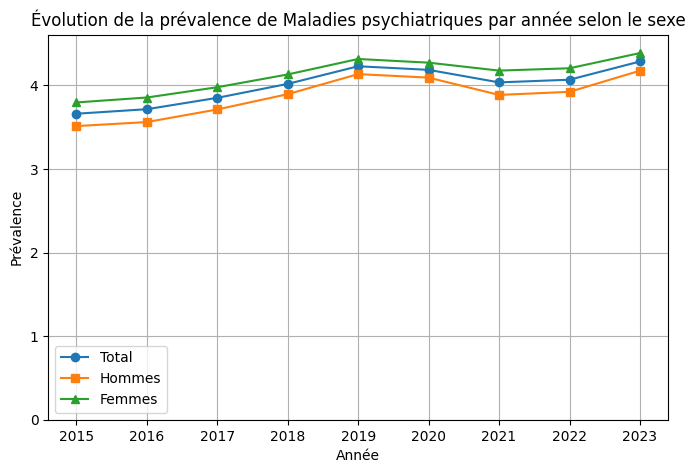

In [15]:
#########Graphique n1 de l'évolution de la prévalence par année selon le sexe pour des pathologies données#########



# Fonction pour calculer la somme de prévalence par année
def somme_preval_par_annee(df):
    return df.groupby("annee")["prev"].sum()

# Filtrer pour sexe = 9 (total ou autre catégorie)
df_sexe9 = df[
    df["libelle_classe_age"].isin(age) &
    df["sexe"].isin([9]) &
    df["dept"].isin(dept) &
    df["top"].isin(top) &
    df["region"].isin(region)
]

# Filtrer pour sexe = 1 (hommes)
df_hommes = df[
    df["libelle_classe_age"].isin(age) &
    df["sexe"].isin([1]) &
    df["dept"].isin(dept) &
    df["top"].isin(top) &
    df["region"].isin(region)
]

# Filtrer pour sexe = 2 (femmes)
df_femmes = df[
     df["libelle_classe_age"].isin(age) &
     df["sexe"].isin([2]) &
     df["dept"].isin(dept) &
     df["top"].isin(top) &
     df["region"].isin(region)
]

# Calcul des séries
serie_sexe9 = somme_preval_par_annee(df_sexe9)
serie_hommes = somme_preval_par_annee(df_hommes)
serie_femmes = somme_preval_par_annee(df_femmes)

# Tracer les trois courbes
plt.figure(figsize=(8,5))
plt.plot(serie_sexe9.index, serie_sexe9.values, marker='o', label='Total')
plt.plot(serie_hommes.index, serie_hommes.values, marker='s', label='Hommes')
plt.plot(serie_femmes.index, serie_femmes.values, marker='^', label='Femmes')

# Génération du titre
titre = "Évolution de la prévalence de " + ", ".join(vals) + " par année selon le sexe"

plt.xlabel("Année")
plt.ylabel("Prévalence")
plt.title(titre) 
plt.grid(True)
plt.ylim(0, max(serie_sexe9.max(), serie_hommes.max(), serie_femmes.max()) * 1.05)
plt.legend()
plt.show()


In [ ]:
#########Graphique n1 bis  l'évolution de la population par année selon le sexe pour des pathologies données#########

# Fonction pour calculer la somme de Ntop par année
def somme_ntop_par_annee(df):
    return df.groupby("annee")["Ntop"].sum()

# Filtrer pour sexe = 9 (total ou autre catégorie)
df_sexe9 = df[
    df["libelle_classe_age"].isin(age) &
    df["sexe"].isin([9]) &
    df["dept"].isin(dept) &
    df["top"].isin(top) &
    df["region"].isin(region)
]

# Filtrer pour sexe = 1 (hommes)
df_hommes = df[
    df["libelle_classe_age"].isin(age) &
    df["sexe"].isin([1]) &
    df["dept"].isin(dept) &
    df["top"].isin(top) &
    df["region"].isin(region)
]

# Filtrer pour sexe = 2 (femmes)
df_femmes = df[
    df["libelle_classe_age"].isin(age) &
    df["sexe"].isin([2]) &
    df["dept"].isin(dept) &
    df["top"].isin(top) &
    df["region"].isin(region)
]

# Calcul des séries
serie_sexe9 = somme_ntop_par_annee(df_sexe9)
serie_hommes = somme_ntop_par_annee(df_hommes)
serie_femmes = somme_ntop_par_annee(df_femmes)

# Tracer les trois courbes
plt.figure(figsize=(8,5))
plt.plot(serie_sexe9.index, serie_sexe9.values, marker='o', label='Total')
plt.plot(serie_hommes.index, serie_hommes.values, marker='s', label='Hommes')
plt.plot(serie_femmes.index, serie_femmes.values, marker='^', label='Femmes')

# Génération du titre
titre = "Évolution de Ntop de " + ", ".join(vals) + " par année selon le sexe"

plt.xlabel("Année")
plt.ylabel("Ntop")
plt.title(titre)
plt.grid(True)
plt.ylim(0, max(serie_sexe9.max(), serie_hommes.max(), serie_femmes.max()) * 1.05)
plt.legend()
plt.show()


In [ ]:
# Récupérer toutes les valeurs uniques (non vides) de patho_niv1 pour pouvoir les appeller plus tard
toutes_les_pathos = df["top"].dropna().unique()

# Afficher le résultat
print(toutes_les_pathos)

In [ ]:
#########Graphique n2 Pyramide des âges pour des pathologies données par année#########
annee_sel = 2022                    # année choisie pour la pyramide


# Sélection des colonnes utiles et conversion
df_reduit = df[["annee", "dept", "region", "libelle_classe_age", "sexe", "Ntop"]].copy()



# Filtrer les données selon les critères
df_filtered = df_reduit[
    df_reduit["dept"].isin(dept) &
    df_reduit["region"].isin(region) &
    (df_reduit["Ntop"].notna()) &
    (df_reduit["Ntop"] != "PSY_CAT_CAT") &
    (df_reduit["libelle_classe_age"] != "tous âges") &
    (df_reduit["annee"] == annee_sel)
]

# Grouper par tranche d'âge et sexe
pivot = df_filtered.groupby(["libelle_classe_age", "sexe"])["Ntop"].sum().unstack(fill_value=0)
pivot = pivot.reindex(sorted(df_filtered["libelle_classe_age"].unique()), fill_value=0)

# Préparer les valeurs pour la pyramide
hommes_neg = -pivot.get(1, pd.Series(np.zeros(len(pivot))))
femmes = pivot.get(2, pd.Series(np.zeros(len(pivot))))


xlim = max(femmes.max(), -hommes_neg.min()) * 1.1  # axe X symétrique
plt.figure(figsize=(8,6))
plt.barh(pivot.index, hommes_neg, color='gold', label='Hommes')
plt.barh(pivot.index, femmes, color='blueviolet', label='Femmes')
plt.xlabel("Nombre de cas")
plt.ylabel("Tranche d'âge")
plt.title(f"Pyramide des âges pour {', '.join(vals)} en {annee_sel}")
plt.xlim(-xlim, xlim)
plt.xticks(np.arange(-xlim, xlim+1, step=int(xlim/5)),
           [abs(int(x)) for x in np.arange(-xlim, xlim+1, step=int(xlim/5))])
plt.grid(axis='x')
plt.legend()
plt.show()


In [ ]:
annee_sel = 2023

# -----------------------------
# Filtrer les données
# -----------------------------
df_filtered = df_reduit[
    df_reduit["dept"].isin(dept) &
    df_reduit["region"].isin(region) &
    (df_reduit["Ntop"].notna()) &
    (df_reduit["Ntop"] != "PSY_CAT_CAT") &
    (df_reduit["libelle_classe_age"] != "tous âges") &
    (df_reduit["annee"] == annee_sel)
]

# -----------------------------
# Calcul des totaux par sexe
# -----------------------------
serie_sexe = df_filtered.groupby("sexe")["Ntop"].sum()
hommes = float(serie_sexe.get(1, 0))
femmes = float(serie_sexe.get(2, 0))

labels = ["Hommes", "Femmes"]
sizes = [hommes, femmes]
total = hommes + femmes

# -----------------------------
# Diagramme circulaire
# -----------------------------
plt.figure(figsize=(6,6))
plt.pie(
    sizes,
    labels=labels,
    colors = ('gold', 'blueviolet'),
    autopct=lambda p: f'{p:.1f}%\n({int(round(p*total/100))})', # ou alors '%1.1f%%' si on veut juste le pourcentage
    startangle=90,
    counterclock=False
)
plt.title(f"Répartition Hommes / Femmes pour {', '.join(vals)} en {annee_sel}")
plt.axis('equal')  # Cercle parfait
plt.show()


In [ ]:
# SAUVEGARDE PRECALCULEE POUR STREAMLIT



In [ ]:
# # Graph ou on selectionne la maladie qu'on veut et on obtient 3 graphiques avec un détail des pathologies qui montre le détail de la pathologie 2 en fonction de la path 1 selectionnée 
# pour le fillna 5 on fait ca car on sait que en moyenne ce sera entre 0 et 10 patients selon ameli
# renommé parce que ca permet de trier correctement en enlevant le 0 
# Menu deroulant ou on peut choisir la path
# toutes_les_pathos = df["patho_niv1"].dropna().unique() affiche juste toutes les pathologies 
# departement 99 = on prend tout 
# df["top"].isin(top) & -> filtre les categories

# quand il y a CAT sur un code top 
# faire une fonction qui attribue un TOP à une catégorie patho1 donnée.

# pouvoir modifier la pyramide des ages en fonction de l'année

# pivot = df_filtered.groupby(["libelle_classe_age", "sexe"])["Ntop"].sum().unstack(fill_value=0)
# on met les colonnes ensemble classe age et sexe et on fait la somme sur ntop 
# > petite passe cleaning du code 
# > scraper un departement dans cahque ville